In [1]:
input_dir = 'input'
output_dir = 'output'

In [2]:
import os
import pandas as pd
import json

df = {}

dataframes = []
for file_name in os.listdir(input_dir):
    if file_name.endswith('.json'):
        file_name, file_extension = os.path.splitext(file_name)
        base_path = os.path.join(input_dir, file_name)

        with open(f'{base_path}.json', 'r') as json_file:
            data = json.load(json_file)
        
        # Use the contents of the text file instead of the json file
        if os.path.isfile(f'{base_path}.txt'):
                with open(f'{base_path}.txt', 'r') as file:
                    data['text'] = file.read().strip()
        
        dataframe = pd.json_normalize(data)
        dataframes.append(dataframe)

    

unbalanced_df = pd.concat(dataframes, ignore_index=True) 

label_columns = [col for col in unbalanced_df.columns if col.startswith('label_')]
analysis_columns = [col for col in unbalanced_df.columns if col.startswith('analysis_')]
categories = [col.replace('label_', '') for col in label_columns]
text_column = 'text'

print(f"Categories: {categories}")
print(f"Labels: {label_columns}")
print(f"Analysis: {analysis_columns}")
print(f"Input: {text_column}")

for type, dataframe in df.items():
    print(f"\nRows ({type}): {len(dataframe)}")
    for category in categories:
        label = f"label_{category}"
        bias = len(dataframe[dataframe[label] == True])
        unbiased = len(dataframe[dataframe[label] == False])
        print(f"\t{category}: {bias} biased, {unbiased} unbiased")
    
    non_neutral = dataframe[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral = dataframe[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    print(f'\tHas at least one bias category: {non_neutral} ({non_neutral/len(dataframe):.2%})')
    print(f'\tHas no bias categories: {neutral} ({neutral/len(dataframe):.2%})')

non_neutral = unbalanced_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
neutral = unbalanced_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

print(f'\nFULL-DATASET Rows: {len(unbalanced_df)}')
print(f'FULL-DATASET Has at least one bias category: {non_neutral} ({non_neutral/len(unbalanced_df):.2%})')
print(f'FULL-DATASET Has no bias categories: {neutral} ({neutral/len(unbalanced_df):.2%})')


Categories: ['age', 'disability', 'masculine', 'feminine', 'racial', 'sexuality', 'general']
Labels: ['label_age', 'label_disability', 'label_masculine', 'label_feminine', 'label_racial', 'label_sexuality', 'label_general']
Analysis: ['analysis_age', 'analysis_disability', 'analysis_masculine', 'analysis_feminine', 'analysis_racial', 'analysis_sexuality', 'analysis_general']
Input: text

FULL-DATASET Rows: 2616
FULL-DATASET Has at least one bias category: 1264 (48.32%)
FULL-DATASET Has no bias categories: 1352 (51.68%)


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_by_category(dataframe, x_ideal=200):
    melted_df = dataframe.melt(id_vars='synthetic', value_vars=label_columns, var_name='categories')
    melted_df = melted_df[melted_df['value'] == 1]
    
    
    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    
    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    total_real_str = '{:,.0f}'.format(non_neutral_real + neutral_real)
    total_synthetic_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic)
    
    pivot_df = melted_df.pivot_table(index='categories', columns='synthetic', aggfunc='size', fill_value=0)
    pivot_df.index = pivot_df.index.str.replace('label_', '')
    pivot_df = pivot_df.sort_values(by=False, ascending=True)
    pivot_df = pivot_df.rename(columns={True: 'Synthetic', False: 'Real'})
    
    plt.figure(figsize=(20, 20))
    bar_plot = pivot_df.plot(kind='barh', stacked=True, color=['#6495ED', '#FFA500'])
    
    plt.title('Verified Biased Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    
    plt.legend([f'{total_real_str} Real', f'{total_synthetic_str} Synthetic'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='')
    
    # Add values onto the chart
    #for rect in bar_plot.patches:
    #    width = rect.get_width()
    #    if width > 0:
    #        y = rect.get_y() + rect.get_height() / 2
    #        x = rect.get_x() + width / 2
    #        bar_plot.text(x, y, str(int(width)), va='center', fontsize=16) 
    
    for rect in bar_plot.patches:
        width, height = rect.get_width(), rect.get_height()
        x, y = rect.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:.0f}'.format(width),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    
    
    # Set x limit 25% more than max value
    plt.xlim(0, pivot_df.values.max() * 1.25)
    
    
    # Draw a vertical line at x = 200
    plt.axvline(x=x_ideal, color="red", linestyle='--')
    
    plt.show()


def plot_neutral_vs_bias(dataframe):
    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    
    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    #print(f'non neutral synthetic: {non_neutral_synthetic}')
    #print(f'non neutral real: {non_neutral_real}')
    #print(f'neutral synthetic: {neutral_synthetic}')
    #print(f'neutral real: {neutral_real}')
    
    total_real_str = '{:,.0f}'.format(non_neutral_real + neutral_real)
    total_synthetic_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic)
    neutral_str = '{:,.0f} Neutral'.format(neutral_synthetic + neutral_real)
    bias_cont_str = '{:,.0f} Bias'.format(non_neutral_synthetic + non_neutral_real)
    total_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic + neutral_real + non_neutral_real)
    
    data = {'Category': [bias_cont_str, bias_cont_str, neutral_str, neutral_str],
            'Count': [non_neutral_synthetic, non_neutral_real, neutral_synthetic, neutral_real],
            'synthetic': ['Synthetic', 'Real', 'Synthetic', 'Real']}
    synth_df = pd.DataFrame(data)
    
    
    plt.figure(figsize=(20, 10))
    
    bar_plot = synth_df['Count'].groupby([synth_df['Category'], synth_df['synthetic']]).sum().unstack().plot.barh(
        stacked=True, color=['#6495ED', '#FFA500'])
    
    plt.title(f'{total_str} Verified Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.legend([f'{total_real_str} Real', f'{total_synthetic_str} Synthetic'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='')
    
    patches = bar_plot.patches
    values = [non_neutral_real,neutral_real,non_neutral_synthetic,neutral_synthetic]
    
    # Display values for each segment
    for patch, value in zip(patches, values):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(value),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    
    plt.show()


def plot_by_models(dataframe):
    dataframe = dataframe[dataframe['synthetic'] == True]

    models = {}
    
    for meta in dataframe['metadata']:
        meta = json.loads(meta)
        model_name = meta['model']
        model_name = model_name.split(':')[-1]
        if model_name not in models:
            models[model_name] = 1
        else:
            models[model_name] += 1


    dataframe = pd.DataFrame(list(models.items()), columns=['Model', 'Count'])
    
    #model_names = dataframe['Model']
    model_counts = dataframe['Count']
    
    plt.figure(figsize=(10, 5))
    
    bar_plot = dataframe['Count'].groupby(dataframe['Model']).sum().plot.barh(color='#6495ED')
    
    plt.title('Verified Synthetic Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    
    patches = bar_plot.patches
    
    # Display values for each segment
    for patch, count in zip(patches, model_counts):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(count),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    plt.show()

# Rebalance

In [4]:
label_columns = [col for col in unbalanced_df.columns if col.startswith('label_')]

unbalanced_df['label_neutral'] = unbalanced_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1)
unbalanced_df['analysis_neutral'] = None
label_columns = [col for col in unbalanced_df.columns if col.startswith('label_')]
unbalanced_df.head(10)

,id,label_age,analysis_age,label_disability,analysis_disability,label_masculine,analysis_masculine,label_feminine,analysis_feminine,label_racial,...,label_sexuality,analysis_sexuality,label_general,analysis_general,verified,synthetic,text,metadata,label_neutral,analysis_neutral
0,Kaggle::techmap::5f7c0f10b35f4b58e69dd69a::ind...,True,"The emphasis on experience in a ""fast paced en...",False,None,False,None,False,None,False,...,False,None,False,None,True,False,SEASONAL. 3 MONTHS - IMMEDIATE START - PARTIAL...,"{""document_id"": ""Kaggle::techmap::5f7c0f10b35f...",False,None
1,Kaggle::techmap::5fa6734ddadf3b09db7e5867::lin...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,False,We're looking for a candidate to fill this pos...,"{""document_id"": ""Kaggle::techmap::5fa6734ddadf...",True,None
2,Kaggle::techmap::612ef01a214d4e19f8d3b560::ree...,False,None,False,None,False,None,False,Asking explicitly for a female is understandab...,False,...,False,None,False,None,True,False,Full-Time Support Worker\n\nLocation: Lowestof...,"{""document_id"": ""Kaggle::techmap::612ef01a214d...",True,None
3,Kaggle::techmap::612f448041083c5b6da08cb7::lin...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,False,"Ability to evaluate, prioritize and problem so...","{""document_id"": ""Kaggle::techmap::612f44804108...",True,None
4,Kaggle::techmap::613aafc9287af26c891c4948::aar...,False,None,True,"The mention of ""Good eye sight (with or withou...",False,None,False,None,False,...,False,None,False,None,True,False,Duties & Responsibilities:\n- Enter data into ...,"{""document_id"": ""Kaggle::techmap::613aafc9287a...",False,None
5,Kaggle::techmap::613ab7bb4243ab478df4c20d::car...,False,"The term ""Tesco will only recruit individuals ...",False,None,False,None,False,None,False,...,False,None,False,None,True,False,28 days annual leave (including bank holidays)...,"{""document_id"": ""Kaggle::techmap::613ab7bb4243...",True,None
6,Kaggle::techmap::613acc7eee58e5261c4cb314::lin...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,False,We are looking for a Recruiter who got what it...,"{""document_id"": ""Kaggle::techmap::613acc7eee58...",True,None
7,Kaggle::techmap::613ae8cdee2b71767d250ea3::aar...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,False,REPORTS TO: General Manager and Corporate Dire...,"{""document_id"": ""Kaggle::techmap::613ae8cdee2b...",True,None
8,Kaggle::techmap::613b1f7491a86b2536b800c5::itj...,False,None,True,"it is not a manual job, therefore comments abo...",False,None,False,None,False,...,False,None,False,None,True,False,"Overview:\nAt CubeSmart, our culture makes the...","{""document_id"": ""Kaggle::techmap::613b1f7491a8...",False,None
9,Kaggle::techmap::613d5a5a4101556d51cf253e::lin...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,False,Provide excellent guest service in an efficien...,"{""document_id"": ""Kaggle::techmap::613d5a5a4101...",True,None


In [5]:
categories = [col.replace('label_', '') for col in label_columns]

ordered_cols = ['id']
label_columns = []
for category in sorted(categories):
    ordered_cols.append(f'label_{category}')
    ordered_cols.append(f'analysis_{category}')
    label_columns.append(f'label_{category}')

ordered_cols.append('verified')
ordered_cols.append('synthetic')
ordered_cols.append('text')
ordered_cols.append('metadata')

unbalanced_df = unbalanced_df[ordered_cols]
unbalanced_df.head(3)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_neutral,analysis_neutral,label_racial,analysis_racial,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata
0,Kaggle::techmap::5f7c0f10b35f4b58e69dd69a::ind...,True,"The emphasis on experience in a ""fast paced en...",False,None,False,None,False,None,False,...,False,None,False,None,False,None,True,False,SEASONAL. 3 MONTHS - IMMEDIATE START - PARTIAL...,"{""document_id"": ""Kaggle::techmap::5f7c0f10b35f..."
1,Kaggle::techmap::5fa6734ddadf3b09db7e5867::lin...,False,None,False,None,False,None,False,None,False,...,True,None,False,None,False,None,True,False,We're looking for a candidate to fill this pos...,"{""document_id"": ""Kaggle::techmap::5fa6734ddadf..."
2,Kaggle::techmap::612ef01a214d4e19f8d3b560::ree...,False,None,False,None,False,Asking explicitly for a female is understandab...,False,None,False,...,True,None,False,None,False,None,True,False,Full-Time Support Worker\n\nLocation: Lowestof...,"{""document_id"": ""Kaggle::techmap::612ef01a214d..."


In [6]:
for col in label_columns:
    v = len(unbalanced_df[unbalanced_df[col] == True])
    print(f'{col}: {v}')

label_age: 201
label_disability: 203
label_feminine: 194
label_general: 204
label_masculine: 198
label_neutral: 1352
label_racial: 194
label_sexuality: 201


In [7]:
max = min(unbalanced_df[col].sum() for col in label_columns)
counts = {}

real_df = unbalanced_df[unbalanced_df['synthetic'] == False]
real_bias_df = real_df[real_df['label_neutral'] == False]

samples = real_bias_df.copy()
for label in label_columns:
    counts[label] = len(samples[samples[label] == True])

counts

{'label_age': 161,
 'label_disability': 93,
 'label_feminine': 31,
 'label_general': 84,
 'label_masculine': 73,
 'label_neutral': 0,
 'label_racial': 44,
 'label_sexuality': 37}

In [8]:
real_neutral_df = real_df[real_df['label_neutral'] == True]
real_neutral_df = real_neutral_df.sample(frac=1, random_state=2024)  # shuffles the dataframe 
real_neutral_df_test = real_neutral_df.iloc[:max, :]  # takes first 194 samples
real_neutral_df_remainder = real_neutral_df.iloc[max:, :]  # takes all the remaining samples

In [9]:
import math


train_split = math.floor(len(real_bias_df) * 0.2)
train_split_neutral = math.floor(len(real_bias_df) * 0.75)
real_bias_df = real_bias_df.sample(frac=1, random_state=2024) 
real_neutral_df = real_neutral_df.sample(frac=1, random_state=2024)  # shuffles the dataframe 
real_train = real_bias_df.iloc[:train_split:,:]
real_test = real_bias_df.iloc[train_split:,:]
real_train_neutral = real_neutral_df.iloc[:train_split_neutral:,:]
real_test_neutral = real_neutral_df.iloc[train_split_neutral:,:]

val_split = math.floor(len(real_test) * 0.5)
val_split_neutral = math.floor(len(real_test_neutral) * 0.5)
real_test = real_test.sample(frac=1, random_state=2024) 
real_test_neutral = real_test_neutral.sample(frac=1, random_state=2024) 
real_val = real_test.iloc[:val_split:,:]
real_test = real_test.iloc[val_split:,:]
real_val_neutral = real_test_neutral.iloc[:val_split_neutral:,:]
real_test_neutral = real_test_neutral.iloc[val_split_neutral:,:]

print('Real Total', len(real_bias_df))
print('Real Train',len(real_train))
print('Real Val',len(real_val))
print('Real Test',len(real_test))

print('Real Test Neutral',len(real_test_neutral))
print('Real Val Neutral',len(real_val_neutral))
print('Real Train Neutral', len(real_train_neutral))

Real Total 392
Real Train 78
Real Val 157
Real Test 157
Real Test Neutral 51
Real Val Neutral 50
Real Train Neutral 294


In [10]:
real_test = pd.concat([real_test, real_test_neutral])
real_val = pd.concat([real_val, real_val_neutral])
real_train = pd.concat([real_train, real_train_neutral])

In [11]:
target = 80

synthetics_df = unbalanced_df[unbalanced_df['synthetic'] == True]
synthetics_df = synthetics_df.sample(frac=1, random_state=2024) 

synthetics_test = {}
synthetics_val = {}
synthetics_remainder = {}
# Test
for label in label_columns:
    synth_df = synthetics_df[synthetics_df[label] == True]
    df = real_test[real_test[label] == True]
    needed = target - len(df) 
    synthetics_test[label] = synth_df.iloc[:needed:,:]
    synthetics_remainder[label] = synth_df.iloc[needed:,:]

# Val
for label in label_columns:
    synth_df = synthetics_remainder[label]
    df = real_val[real_val[label] == True]
    needed = target - len(df) 
    synthetics_val[label] = synth_df.iloc[:needed:,:]
    synthetics_remainder[label] = synth_df.iloc[needed:,:]

df_test = real_test.copy()
for label in label_columns:
    df_test = pd.concat([df_test,synthetics_test[label]])

df_val = real_val.copy()
for label in label_columns:
    df_val = pd.concat([df_val,synthetics_val[label]])

df_train = real_train.copy()
for label in label_columns:
    df_train = pd.concat([df_train,synthetics_remainder[label]])


In [12]:
len(df_train)

1439

<Figure size 1440x1440 with 0 Axes>

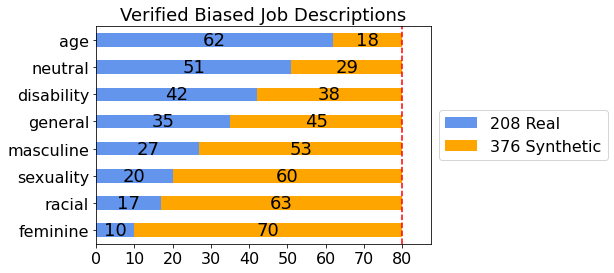

In [13]:
plot_by_category(df_test,80)

<Figure size 1440x1440 with 0 Axes>

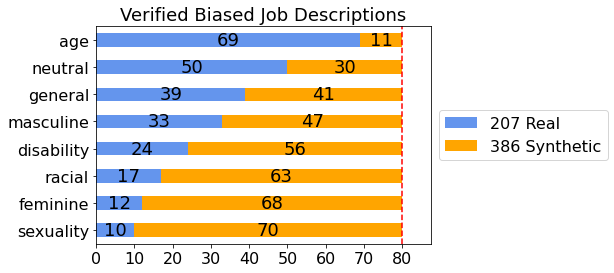

In [14]:
plot_by_category(df_val,80)


<Figure size 1440x1440 with 0 Axes>

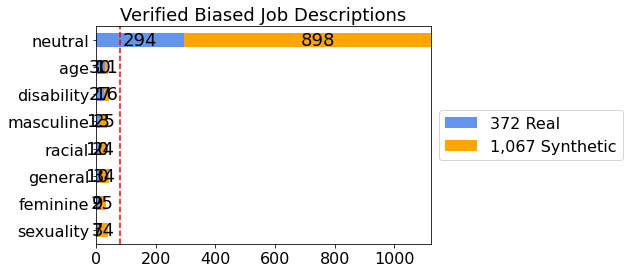

In [15]:
plot_by_category(df_train,80)

In [16]:
df_train.to_parquet(f'output/verified-train.parquet')
df_val.to_parquet(f'output/verified-val.parquet')
df_test.to_parquet(f'output/verified-test.parquet')